In [3]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.metrics import rand_score
from sklearn.cluster import KMeans
import time

In [4]:
def coreset(data, m):
    N = data.shape[0]
    
    mean = np.mean(data, axis=0)
    
    q = np.linalg.norm(data - mean, axis=1)**2
    sum = np.sum(q)
    q = 0.5 * (1.0/N + q/sum)
    
    samples = np.random.choice(N, m, p=q)
    coreset = data[samples]
    weights = 1.0 / (q[samples] * m)
    
    return coreset, weights 

In [5]:
def kmeans_cost(data, centers, labels):
    cost = 0.0
    for i in range(len(data)):
        distance = np.linalg.norm(data[i] - centers[labels[i]]) ** 2
        cost += distance
    return cost

In [6]:
traindata = pd.DataFrame(pd.read_csv("bio_train.dat", sep="\t", header=None))
traindata = traindata.dropna()
traindata = traindata.drop_duplicates()
traindata = traindata[:10000]

In [7]:
kmeans = KMeans(n_clusters=50, init='k-means++', random_state=42).fit(traindata)
centers = kmeans.cluster_centers_

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of

In [8]:
cost = kmeans_cost(traindata.values, centers, kmeans.labels_)
optimal_labels = kmeans.labels_
print(f'Cost of KMeans: {cost}')

Cost of KMeans: 20404258731.815243


In [46]:
def get_results(coreset_size, n_clusters, X, optimal_labels, cost, data_name):
    results = []
    for ssize in coreset_size:
        avg_cost = 0
        start_time = time.time()
        rand_index = 0.0
        for _ in range(5):
            X_sample, weight = coreset(X, ssize)
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++').fit(X_sample, sample_weight=weight)
            labels = kmeans.predict(X)
            centers = kmeans.cluster_centers_
            avg_cost += kmeans_cost(X, centers, labels)
            rand_index += rand_score(optimal_labels, labels)
        rand_index /= 5
        end_time = time.time()
        avg_cost /= 5
        reduction = ((X.shape[0] - X_sample.shape[0])/X.shape[0])*100
        error = (abs(avg_cost - cost)/cost)*100
        results.append({'Sampling Type': 'Lightweight Coresets',
                            'Coreset Size': X_sample.shape[0],
                            'Average Cost': avg_cost,
                            'Reduction in Data Size': reduction,
                            'Error': error,
                            'Avg Rand Index': rand_index,
                            'Data': data_name,
                            'Optimal Cost': cost,
                            'Avg Time': (end_time - start_time)/5})
    return results

In [17]:
results = get_results([100, 500, 1000, 1500, 3500, 5000, 7000, 10000], 50, traindata.values, optimal_labels, cost)

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

In [18]:
result_df = pd.DataFrame(results)
result_df.head()

,Sampling Type,Coreset Size,Average Cost,Reduction in Data Size,Error,Avg Rand Index,Data,Optimal Cost,Avg Time
0,Lightweight Coresets,100,6.972394e+10,99.0,241.712680,0.977366,KDD,2.040426e+10,0.135646
1,Lightweight Coresets,500,4.015167e+10,95.0,96.780837,0.982115,KDD,2.040426e+10,0.155557
2,Lightweight Coresets,1000,4.367793e+10,90.0,114.062795,0.984147,KDD,2.040426e+10,0.188644
3,Lightweight Coresets,1500,4.414912e+10,85.0,116.372106,0.981608,KDD,2.040426e+10,0.228206
4,Lightweight Coresets,3500,2.897425e+10,65.0,42.000973,0.985337,KDD,2.040426e+10,0.364209


In [20]:
result_df['Coreset Size']

0      100
1      500
2     1000
3     1500
4     3500
5     5000
6     7000
7    10000
Name: Coreset Size, dtype: int64

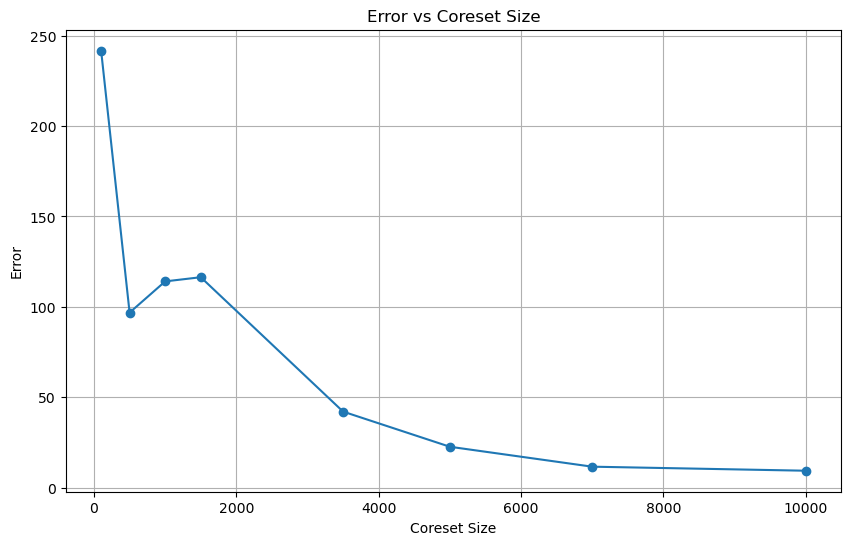

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['Coreset Size'], result_df['Error'], marker='o')
plt.xlabel('Coreset Size')
plt.ylabel('Error')
plt.title('Error vs Coreset Size')
plt.grid()
plt.show()

In [21]:
df = pd.read_csv('results.csv')

In [23]:
# Append the new results to the existing results
df = pd.concat([df, result_df], ignore_index=True)

In [25]:
df

,Sampling Type,Coreset Size,Average Cost,Reduction in Data Size,Error,Avg Rand Index,Data,Optimal Cost,Avg Time,Num Iterations Volume Sampling
0,Volume Sampling,474,1.150492e+11,95.26,463.848772,0.963519,KDD,2.040426e+10,0.211612,1.0
1,Volume Sampling,475,1.326848e+11,95.25,550.279722,0.966513,KDD,2.040426e+10,0.221085,2.0
2,Volume Sampling,478,1.755777e+11,95.22,760.495267,0.953055,KDD,2.040426e+10,0.255715,5.0
3,Volume Sampling,926,5.792439e+10,90.74,183.883834,0.972418,KDD,2.040426e+10,0.265303,1.0
4,Volume Sampling,906,8.645982e+10,90.94,323.734209,0.966581,KDD,2.040426e+10,0.298187,2.0
5,Volume Sampling,912,7.780551e+10,90.88,281.319944,0.968966,KDD,2.040426e+10,0.419084,5.0
6,Volume Sampling,1690,7.217500e+10,83.10,253.725160,0.969566,KDD,2.040426e+10,0.489570,1.0
7,Volume Sampling,1703,4.226911e+10,82.97,107.158249,0.972932,KDD,2.040426e+10,0.555935,2.0
8,Volume Sampling,1687,6.531628e+10,83.13,220.110994,0.969281,KDD,2.040426e+10,0.775477,5.0
9,Volume Sampling,3374,4.104425e+10,66.26,101.155317,0.973963,KDD,2.040426e+10,1.168374,1.0


In [26]:
X, y = make_blobs(n_samples=10000, centers=50, n_features=100, random_state=42)

In [27]:
kmeans = KMeans(n_clusters=50, init='k-means++', random_state=42).fit(X)
centers = kmeans.cluster_centers_
optimal_labels = kmeans.labels_
cost = kmeans_cost(X, centers, kmeans.labels_)
print(f'Cost of KMeans: {cost}')

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cost of KMeans: 995625.8122608332


In [31]:
results = get_results([100, 500, 1000, 1500, 3500, 5000, 7000, 10000], 50, X, optimal_labels, cost)

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

In [32]:
results

[{'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 100,
  'Average Cost': 7483374.619859976,
  'Reduction in Data Size': 99.0,
  'Error': 651.6252117717783,
  'Avg Rand Index': 0.9950955135513551,
  'Data': 'Synthetic',
  'Optimal Cost': 995625.8122608332,
  'Avg Time': 0.1406777858734131},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 500,
  'Average Cost': 1108427.9183005665,
  'Reduction in Data Size': 95.0,
  'Error': 11.329769141238524,
  'Avg Rand Index': 1.0,
  'Data': 'Synthetic',
  'Optimal Cost': 995625.8122608332,
  'Avg Time': 0.14890403747558595},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 1000,
  'Average Cost': 1047152.8040605362,
  'Reduction in Data Size': 90.0,
  'Error': 5.175337075953991,
  'Avg Rand Index': 1.0,
  'Data': 'Synthetic',
  'Optimal Cost': 995625.8122608332,
  'Avg Time': 0.16928720474243164},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 1500,
  'Average Cost': 1028770.3941217292,
  'Reduction 

In [33]:
df = pd.concat([df, pd.DataFrame(results)], ignore_index=True)
df

,Sampling Type,Coreset Size,Average Cost,Reduction in Data Size,Error,Avg Rand Index,Data,Optimal Cost,Avg Time,Num Iterations Volume Sampling
0,Volume Sampling,474,1.150492e+11,95.26,463.848772,0.963519,KDD,2.040426e+10,0.211612,1.0
1,Volume Sampling,475,1.326848e+11,95.25,550.279722,0.966513,KDD,2.040426e+10,0.221085,2.0
2,Volume Sampling,478,1.755777e+11,95.22,760.495267,0.953055,KDD,2.040426e+10,0.255715,5.0
3,Volume Sampling,926,5.792439e+10,90.74,183.883834,0.972418,KDD,2.040426e+10,0.265303,1.0
4,Volume Sampling,906,8.645982e+10,90.94,323.734209,0.966581,KDD,2.040426e+10,0.298187,2.0
5,Volume Sampling,912,7.780551e+10,90.88,281.319944,0.968966,KDD,2.040426e+10,0.419084,5.0
6,Volume Sampling,1690,7.217500e+10,83.10,253.725160,0.969566,KDD,2.040426e+10,0.489570,1.0
7,Volume Sampling,1703,4.226911e+10,82.97,107.158249,0.972932,KDD,2.040426e+10,0.555935,2.0
8,Volume Sampling,1687,6.531628e+10,83.13,220.110994,0.969281,KDD,2.040426e+10,0.775477,5.0
9,Volume Sampling,3374,4.104425e+10,66.26,101.155317,0.973963,KDD,2.040426e+10,1.168374,1.0


In [34]:
df.to_csv('results.csv', index=False)

In [35]:
import torch
from torchvision import datasets, transforms
import numpy as np

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/shubhagarwal/anaconda3/envs/NLP/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <D2077E4D-18BC-34B9-8A9B-1EF634A0F416> /Users/shubhagarwal/anaconda3/envs/NLP/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update 

In [43]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_test = test_dataset.targets.numpy()

In [44]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [45]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42).fit(X_train)
centers = kmeans.cluster_centers_
optimal_labels = kmeans.labels_
cost = kmeans_cost(X_train, centers, kmeans.labels_)
print(f'Cost of KMeans: {cost}')

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cost of KMeans: 1906652.134114885


In [47]:
results = get_results([100, 500, 1000, 1500, 3500, 5000, 7000, 10000, 20000], 10, X_train, optimal_labels, cost, 'FMNIST')

/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/shubhagarwal/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

In [48]:
results

[{'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 100,
  'Average Cost': 2158636.326811089,
  'Reduction in Data Size': 99.83333333333333,
  'Error': 13.216054894732093,
  'Avg Rand Index': 0.9262602944493519,
  'Data': 'FMNIST',
  'Optimal Cost': 1906652.134114885,
  'Avg Time': 0.7076163768768311},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 500,
  'Average Cost': 1964584.322251501,
  'Reduction in Data Size': 99.16666666666667,
  'Error': 3.038424634471121,
  'Avg Rand Index': 0.9439008477919076,
  'Data': 'FMNIST',
  'Optimal Cost': 1906652.134114885,
  'Avg Time': 0.8357719898223877},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size': 1000,
  'Average Cost': 1952921.3907622057,
  'Reduction in Data Size': 98.33333333333333,
  'Error': 2.4267277611602722,
  'Avg Rand Index': 0.9322383896398273,
  'Data': 'FMNIST',
  'Optimal Cost': 1906652.134114885,
  'Avg Time': 0.8374724388122559},
 {'Sampling Type': 'Lightweight Coresets',
  'Coreset Size':

In [50]:
df = pd.concat([df, pd.DataFrame(results)], ignore_index=True)
df

,Sampling Type,Coreset Size,Average Cost,Reduction in Data Size,Error,Avg Rand Index,Data,Optimal Cost,Avg Time,Num Iterations Volume Sampling
0,Volume Sampling,474,1.150492e+11,95.260000,463.848772,0.963519,KDD,2.040426e+10,0.211612,1.0
1,Volume Sampling,475,1.326848e+11,95.250000,550.279722,0.966513,KDD,2.040426e+10,0.221085,2.0
2,Volume Sampling,478,1.755777e+11,95.220000,760.495267,0.953055,KDD,2.040426e+10,0.255715,5.0
3,Volume Sampling,926,5.792439e+10,90.740000,183.883834,0.972418,KDD,2.040426e+10,0.265303,1.0
4,Volume Sampling,906,8.645982e+10,90.940000,323.734209,0.966581,KDD,2.040426e+10,0.298187,2.0
...,...,...,...,...,...,...,...,...,...,...
62,Lightweight Coresets,3500,1.919632e+06,94.166667,0.680786,0.964250,FMNIST,1.906652e+06,1.470711,NaN
63,Lightweight Coresets,5000,1.914712e+06,91.666667,0.422711,0.981262,FMNIST,1.906652e+06,2.005592,NaN
64,Lightweight Coresets,7000,1.916026e+06,88.333333,0.491659,0.972177,FMNIST,1.906652e+06,2.750548,NaN
65,Lightweight Coresets,10000,1.912398e+06,83.333333,0.301370,0.979475,FMNIST,1.906652e+06,6.492139,NaN


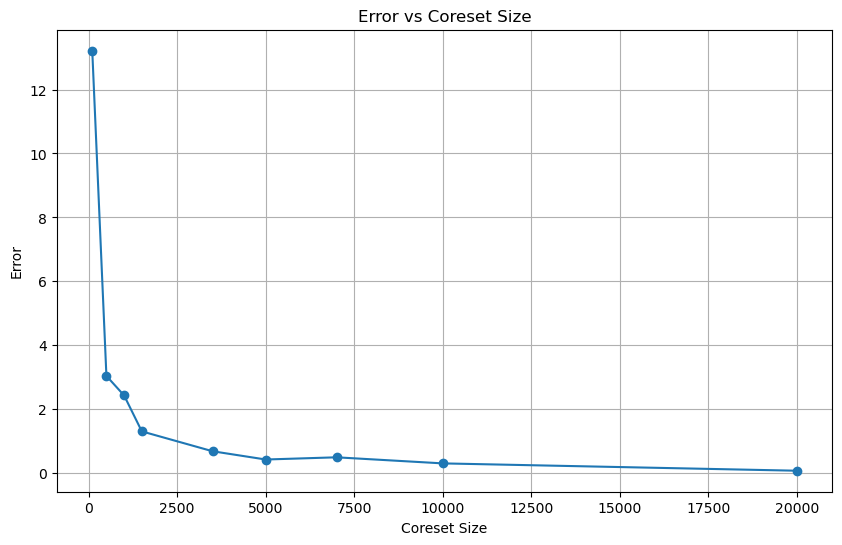

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(df[df['Data'] == 'FMNIST']['Coreset Size'], df[df['Data'] == 'FMNIST']['Error'], marker='o')
plt.xlabel('Coreset Size')
plt.ylabel('Error')
plt.title('Error vs Coreset Size')
plt.grid()
plt.show()

In [52]:
df.to_csv('results.csv', index=False)

In [53]:
fb = pd.read_json('musae_facebook_features.json')
fb.head()

ValueError: All arrays must be of the same length